<center><h1>Kelompok 11 Project PCD</h1></center>

<center>
F1D022006 - GUSTI AYU DEVI ANJANI PUTRI<br>
F1D022137 - MUH. RESSA ARSY MA'RIF<br>
F1D022138 - MUHAMAD ZIBAN THABRANI<br>
F1D022119 - FADILA RAMDHANI MUAZ<br>
F1D022017 - NI PUTU ALVINA PUTRI
</center>

In [180]:
# Import library yang diperlukan
import os
os.chdir(r'D:\Project PCD\Ekspresi') 
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score


Berikut adalah penjelasan singkat mengenai library yang digunakan:

import os : Mengimpor modul os yang digunakan untuk melakukan interaksi dengan sistem operasi.
os.chdir(r'D:\Project PCD\Ekspresi') : Mengubah direktori kerja saat ini ke 'D:\Project PCD\Ekspresi'.
import cv2 : digunakan untuk computer vision dan image processing.
import numpy as np : untuk operasi matematika pada array dan matriks.
import matplotlib.pyplot as plt : untuk membuat visualisasi grafik dan plot.
import math : menyediakan fungsi-fungsi matematika.
import pandas as pd : digunakan untuk analisis data.
from tqdm import tqdm : untuk menciptakan progress bars saat iterasi.
import seaborn as sns : untuk membuat visualisasi data statistik.
from sklearn.decomposition import PCA : untuk analisis Principal Component Analysis.
from sklearn.model_selection import train_test_split : untuk membagi dataset menjadi data latih dan data uji.
from sklearn.preprocessing import StandardScaler : untuk standarisasi fitur-fitur.
from sklearn.neighbors import KNeighborsClassifier : untuk model klasifikasi K-Nearest Neighbors.
from sklearn.svm import SVC : untuk Support Vector Classification.
from sklearn.ensemble import RandomForestClassifier : Mengimpor RandomForestClassifier untuk model klasifikasi Random Forest.
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score : Mengimpor berbagai metrik evaluasi klasifikasi seperti akurasi, confusion matrix, precision, recall, dan F1 score.

## Data Loading

Fungsi 'load_resize_augment_images_from_folders'  berperan penting dalam memproses data gambar untuk analisis ekspresi wajah. Melalui fungsi ini, gambar-gambar dari folder-folder 'Angry', 'Happy', dan 'Sad' di-load, diresize ke ukuran target 150x150, dan diaugmentasi. Gambar-gambar ini kemudian disimpan ke dalam list images beserta label dari setiap gambar yang diambil dari nama foldernya, serta dihitung jumlah gambar dalam setiap folder.

Setelah proses load, resize, dan augmentasi selesai, dilakukan pengecekan jumlah total gambar yang telah dimuat, serta visualisasi dalam bentuk grafik batang yang memperlihatkan jumlah gambar per folder. Langkah-langkah ini merupakan persiapan yang penting sebelum melanjutkan ke tahap selanjutnya dalam analisis data, seperti ekstraksi fitur, pemodelan klasifikasi, dan evaluasi performa model. Dengan demikian, proses ini membantu dalam memahami distribusi data gambar ekspresi wajah yang akan digunakan dalam pengembangan model klasifikasi.

Loaded 750 images.
Sample image shape: (150, 150, 3)
Sample label: Angry


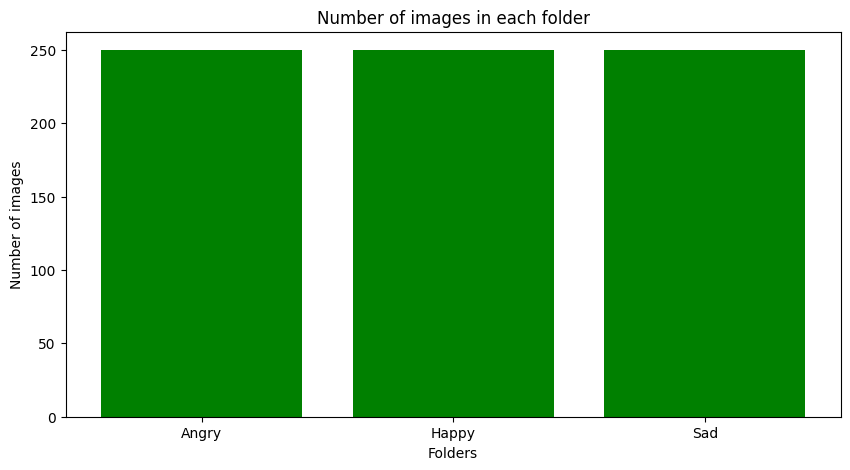

In [227]:
# Function untuk load, resize, dan augmentasi gambar dari folder
def load_resize_augment_images_from_folders(folders, target_size=(150, 150)):
    images = []
    labels = []
    folder_image_count = {}
    augmented_samples = {folder: [] for folder in folders}  # dictionary untuk menyimpan gambar hasil augmentasi
    
    for folder_path in folders:
        folder_name = os.path.basename(folder_path)
        folder_image_count[folder_name] = 0
        
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, target_size)
                images.append(img)
                label = folder_name  # label dari nama folder
                labels.append(label)
                
                folder_image_count[folder_name] += 1
                
                # Augmentasi gambar dan menambahkannya ke list augmented_samples
                augmented_samples[folder_name].extend(augment_image(img))
    
    return images, labels, folder_image_count, augmented_samples

# Folder paths
folder_paths = ['Angry', 'Happy', 'Sad']

# Load, resize, dan augmentasi gambar
images, labels, folder_image_count, augmented_samples = load_resize_augment_images_from_folders(folder_paths)

# Cek nomor percobaan
print(f"Loaded {len(images)} images.")
print(f"Sample image shape: {images[0].shape}")
print(f"Sample label: {labels[0]}")

# Plot menampilkan jumlah gambar per folder
plt.figure(figsize=(10, 5))
plt.bar(folder_image_count.keys(), folder_image_count.values(), color='green')
plt.xlabel('Folders')
plt.ylabel('Number of images')
plt.title('Number of images in each folder')
plt.show()

## Data Preparation

### Data Augmentation

Fungsi augment_image(image) yang telah dibuat bertujuan untuk melakukan augmentasi gambar dengan variasi rotasi dan flipping. Proses augmentasi dilakukan dengan membuat salinan dari gambar input image yang telah dirotasi sebanyak 30 derajat searah jarum jam, 30 derajat berlawanan arah jarum jam, serta dilakukan flipping horizontal dan vertical. Selain itu, dilakukan pula proses flipping setelah rotasi. Setiap gambar hasil augmentasi disimpan dalam list augmented_images dan dikembalikan keluar dari fungsi.

Setelah proses augmentasi selesai, dilakukan visualisasi untuk membandingkan gambar asli dengan gambar hasil augmentasi. Setiap folder ('Angry', 'Happy', 'Sad') akan menampilkan gambar original diikuti dengan 6 contoh gambar hasil augmentasi. Gambar-gambar ini ditampilkan dalam subplot untuk setiap folder secara berdampingan, memberikan visualisasi yang berguna untuk memahami variasi gambar yang dihasilkan setelah proses augmentasi. Proses ini membantu dalam melihat efek augmentasi terhadap data gambar yang digunakan untuk melatih model klasifikasi ekspresi wajah.

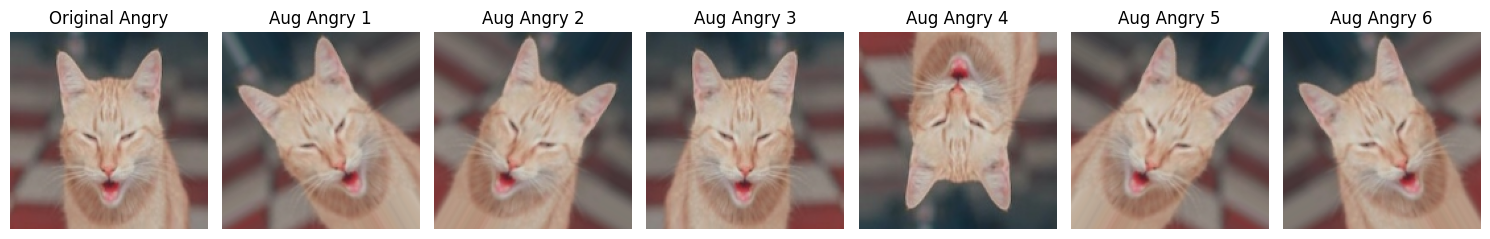

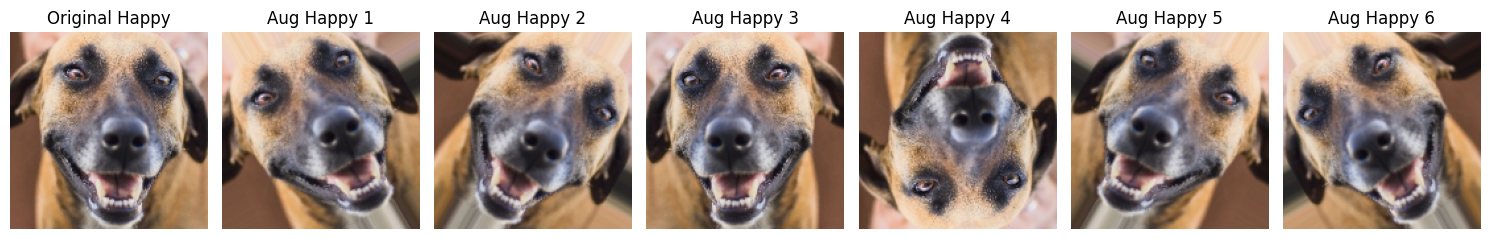

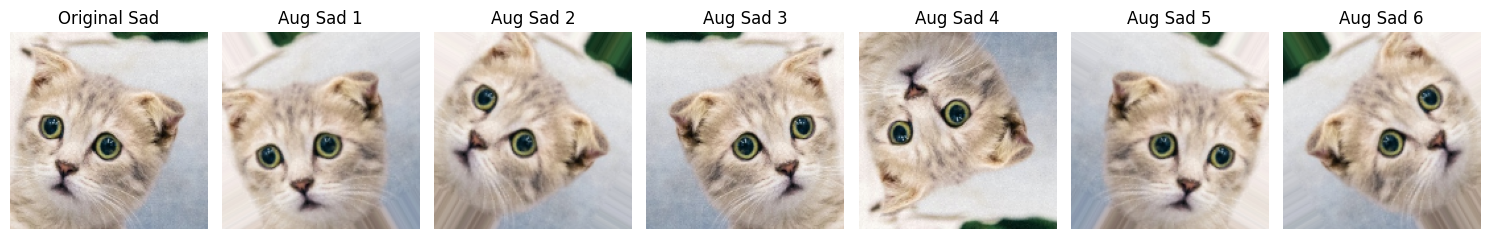

In [228]:
def augment_image(image):
    height, width = image.shape[:2]
    augmented_images = []

    # Function untuk rotasi dan flip
    def rotate_image(image, angle):
        image_center = tuple(np.array(image.shape[1::-1]) / 2)
        rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
        abs_cos = abs(rot_mat[0,0])
        abs_sin = abs(rot_mat[0,1])
        
        bound_w = int(height * abs_sin + width * abs_cos)
        bound_h = int(height * abs_cos + width * abs_sin)
        
        rot_mat[0, 2] += bound_w / 2 - image_center[0]
        rot_mat[1, 2] += bound_h / 2 - image_center[1]
        
        rotated_img = cv2.warpAffine(image, rot_mat, (bound_w, bound_h), borderMode=cv2.BORDER_REPLICATE)
        
        crop_x = (bound_w - width) // 2
        crop_y = (bound_h - height) // 2
        cropped_img = rotated_img[crop_y:crop_y + height, crop_x:crop_x + width]
        
        return cropped_img

    # Flipping function
    def flip_image(image, flip_code):
        return cv2.flip(image, flip_code)

    # melakukan augmentasi dan menambahkan ke list
    rotated1 = rotate_image(image, 30)
    augmented_images.append(rotated1)

    rotated2 = rotate_image(image, -30)
    augmented_images.append(rotated2)

    flipped_h = flip_image(image, 1)
    augmented_images.append(flipped_h)

    flipped_v = flip_image(image, 0)
    augmented_images.append(flipped_v)

    rotated_flipped1 = flip_image(rotated1, 1)
    augmented_images.append(rotated_flipped1)

    rotated_flipped2 = flip_image(rotated2, 1)
    augmented_images.append(rotated_flipped2)

    return augmented_images


# Menampilkan sample gambar original dan augmented
for folder in folder_paths:
    sample_image = images[labels.index(folder)]
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 7, 1)
    plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
    plt.title(f'Original {folder}')
    plt.axis('off')

    for i, aug_img in enumerate(augmented_samples[folder][:6]):
        plt.subplot(1, 7, i+2)
        plt.imshow(cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB))
        plt.title(f'Aug {folder} {i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

Pada blok kode di bawah, terdapat sebuah iterasi yang dilakukan untuk setiap folder yang terdapat dalam folder_paths, yaitu 'Angry', 'Happy', dan 'Sad'. Setiap iterasi akan menghitung jumlah gambar hasil augmentasi yang telah disimpan dalam dictionary augmented_samples untuk folder tersebut dan mencetak jumlah tersebut. Proses ini bermanfaat untuk memberikan informasi mengenai jumlah gambar hasil augmentasi yang telah dibuat untuk setiap kategori ekspresi wajah ('Angry', 'Happy', 'Sad'). Dengan demikian, informasi ini membantu dalam pemahaman tentang jumlah variasi data yang tersedia setelah proses augmentasi dilakukan, yang pada gilirannya dapat berpengaruh pada kualitas dan keberagaman data yang digunakan untuk melatih model klasifikasi.

In [183]:
for folder in folder_paths:
    num_augmented_images = len(augmented_samples[folder])
    print(f'Jumlah augmented images dalam folder {folder}: {num_augmented_images}')

Jumlah augmented images dalam folder Angry: 1500
Jumlah augmented images dalam folder Happy: 1500
Jumlah augmented images dalam folder Sad: 1500


### Preprocessing

#### GrayScale

Pada blok kode di bawah, dilakukan konversi gambar hasil augmentasi dari format warna BGR (Blue-Green-Red) ke grayscale menggunakan fungsi cv2.cvtColor(img, cv2.COLOR_BGR2GRAY). Konversi ini dilakukan untuk setiap gambar hasil augmentasi yang disimpan dalam dictionary augmented_samples untuk masing-masing kategori ekspresi wajah ('Angry', 'Happy', 'Sad'). Hasil dari konversi gambar ke grayscale disimpan dalam dictionary baru gray_images dengan struktur yang serupa dengan augmented_samples.

Setelah proses konversi selesai, dilakukan visualisasi gambar-gambar grayscale untuk masing-masing kategori ekspresi wajah. Setiap folder ('Angry', 'Happy', 'Sad') akan menampilkan 6 contoh gambar grayscale yang dihasilkan setelah konversi. Gambarnya ditampilkan dalam bentuk subplot dengan masing-masing subplot menampilkan salah satu contoh gambar grayscale. Proses visualisasi ini membantu dalam melihat representasi gambar dalam skala keabuan (grayscale) dan memahami bagaimana perubahan format warna dapat mempengaruhi tampilan gambar sebelum dilakukan tahap analisis lebih lanjut, seperti ekstraksi fitur atau pelatihan model

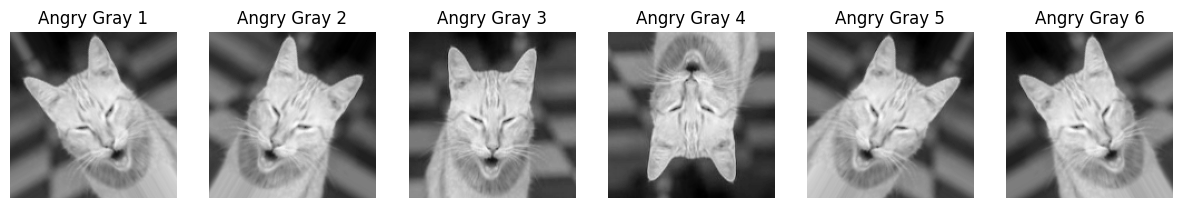

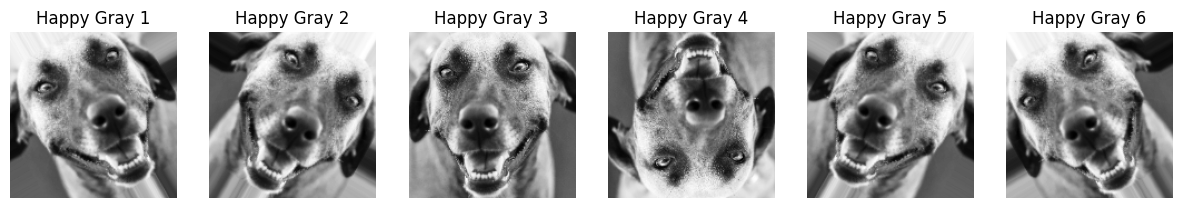

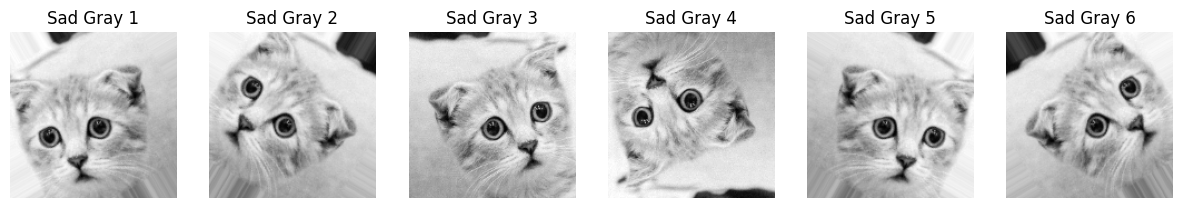

In [184]:
# Convert images ke grayscale
gray_images = {folder: [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in augmented_samples[folder]] for folder in folder_paths}

# menampilkan gambar sample grayscale
for folder in folder_paths:
    plt.figure(figsize=(15, 5))
    for i in range(6):
        plt.subplot(1, 6, i+1)
        plt.imshow(gray_images[folder][i], cmap='gray')
        plt.title(f'{folder} Gray {i+1}')
        plt.axis('off')
    plt.show()

### Sharpening

In [185]:
kernelSharp = np.array([
    [1/9,1/9,1/9],
    [1/9,8/9,1/9],
    [1/9,1/9,1/9],
])


Membuat kernel untuk proses sharpening

In [186]:
def getPadding (image, kernel):
    i = (kernel.shape[1]-1)//2
    j = (kernel.shape[0]-1)//2
    kiri = i
    kanan = (kernel.shape[1]-1)-i
    atas = j
    bawah = (kernel.shape[0]-1)-j
    result = np.pad(image,((atas,bawah),(kiri,kanan)), 'constant',constant_values=0)
    return result

Membuat fungsi untuk menambahkan zero padding 

In [187]:
def konvolusi(image, kernel):
    result = np.zeros(image.shape).astype(int)
    pad = getPadding(image, kernel)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            sum = 0
            for k in range(kernel.shape[0]):
                for l in range(kernel.shape[1]):
                    sum+= pad[i+k][j+l] * kernel[k,l]

            result[i,j] = sum

    return result


Membuat fungsi untuk konvolusi

Melakukan sharperning kepada seluruh gambar pada folder "gray_images" dengan kernel yang sudah dibuat sebelumnya.

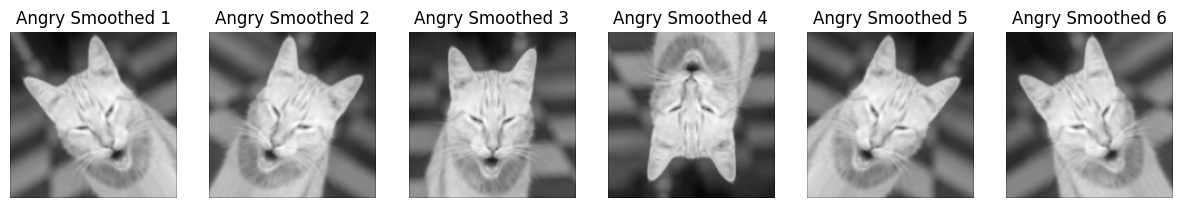

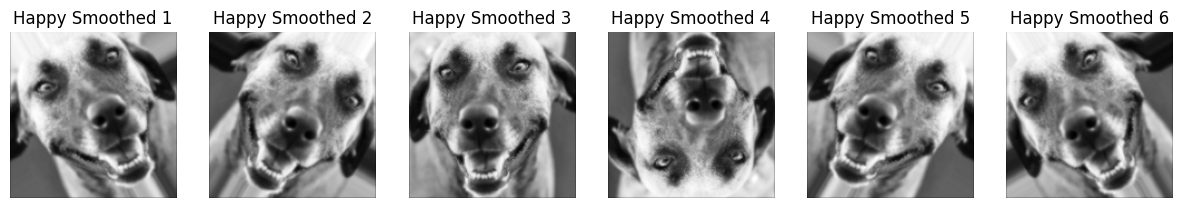

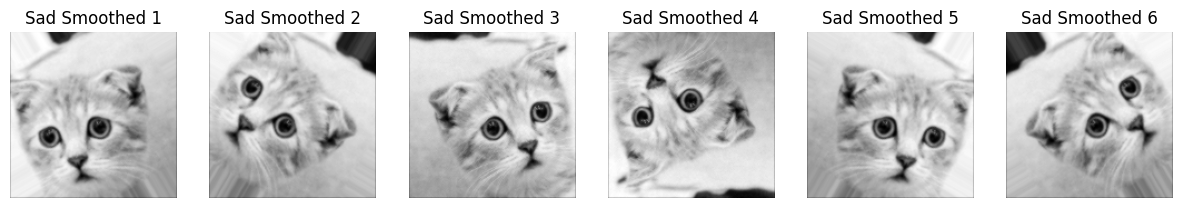

In [189]:
sharp_images = {folder: [konvolusi(img, kernelSharp) for img in gray_images[folder]] for folder in folder_paths}

for folder in folder_paths:
    plt.figure(figsize=(15, 5))
    for i in range(6):
        plt.subplot(1, 6, i+1)
        plt.imshow(sharp_images[folder][i], cmap='gray')
        plt.title(f'{folder} Smoothed {i+1}')
        plt.axis('off')
    plt.show()

### Normalisasi

Melakukan proses normalisasi gambar hasil sharpening dengan melakukan pembagian intensitas piksel pada setiap gambar dengan nilai 255.0. Proses normalisasi ini bertujuan untuk mengubah rentang nilai intensitas piksel dalam gambar ke rentang antara 0 dan 1, yang digunakan untuk standarisasi intensitas piksel agar model klasifikasi dapat belajar dan beroperasi lebih efisien. Setiap gambar hasil normalisasi (normalized images) kemudian ditampilkan dalam bentuk subplot untuk masing-masing kategori ekspresi wajah ('Angry', 'Happy', 'Sad') untuk memberikan visualisasi representasi gambar yang sudah dinormalisasi, memudahkan dalam pemahaman perubahan intensitas piksel setelah proses normalisasi dilakukan sebelum dilanjutkan ke tahapan analisis selanjutnya.

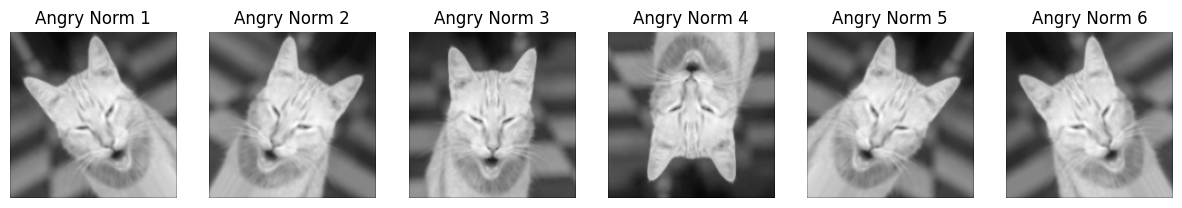

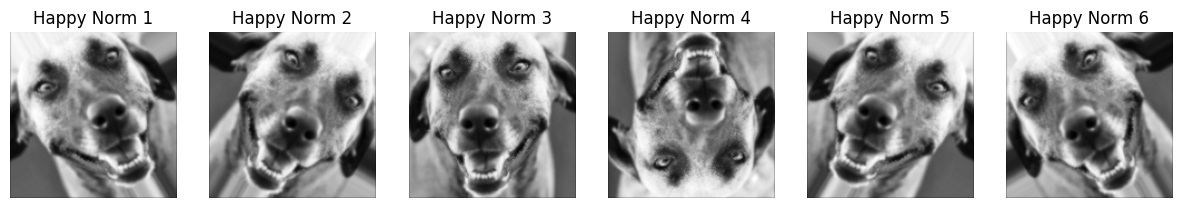

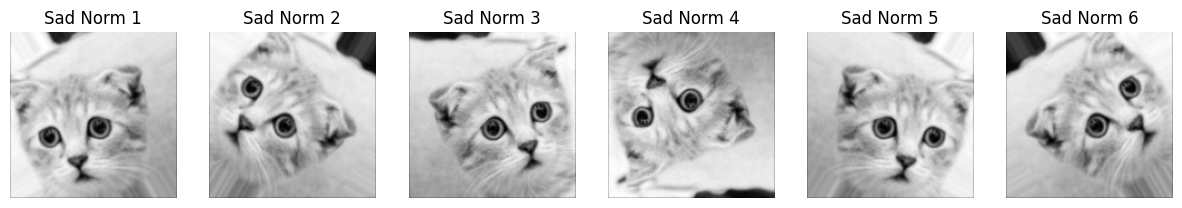

In [190]:
normalized_images = {folder: [img / 255.0 for img in sharp_images[folder]] for folder in folder_paths}

for folder in folder_paths:
    plt.figure(figsize=(15, 5))
    for i in range(6):
        plt.subplot(1, 6, i+1)
        plt.imshow(normalized_images[folder][i], cmap='gray')
        plt.title(f'{folder} Norm {i+1}')
        plt.axis('off')
    plt.show()

## Deteksi Tepi dengan Sobel

In [191]:

def deteksiTepi(image, kernelX, kernelY):
    result = np.zeros(image.shape).astype(int)  # Initialize result array
    
    # Pad the image using the getPadding function
    imgPad = getPadding(image, kernelX)
    
    # Perform convolution and edge detection
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            x = 0
            y = 0
            for k in range(kernelX.shape[0]):
                for l in range(kernelX.shape[1]):
                    x += imgPad[i+k][j+l] * kernelX[k, l]
                    y += imgPad[i+k][j+l] * kernelY[k, l]
            result[i, j] = int(math.sqrt(x*x + y*y))  # Calculate gradient magnitude
    
    return result


Fungsi deteksiTepi(image, kernelX, kernelY) yang didefinisikan di atas bertujuan untuk melakukan deteksi tepi (edge detection) pada sebuah gambar grayscale image menggunakan dua buah kernel kernelX dan kernelY. Proses deteksi tepi dilakukan dengan melakukan konvolusi antara gambar input dan dua kernel tepi, yaitu kernelX dan kernelY. KernelX dan kernelY biasanya merupakan kernel Sobel atau kernel lainnya yang dimaksudkan untuk mengekstrak informasi tepi secara horizontal dan vertikal dari gambar. Algoritma deteksi tepi dilakukan dengan menghitung gradien gambar dalam arah horizontal (x) dan vertikal (y), lalu menghitung magnitudo gradien sebagai representasi kekuatan tepi pada setiap piksel. Hasil deteksi tepi, yang merupakan magnitudo gradien dari arah horizontal dan vertikal, disimpan dalam array result dan dikembalikan sebagai output fungsi. Proses ini membantu dalam mendeteksi struktur tepi atau kontur pada gambar yang penting dalam proses analisis citra.

In [192]:
kernelXS = np.array([
    [-1,0,1],
    [-2,0,2],
    [-1,0,1]
])
kernelYS = np.array([
    [1,2,1],
    [0,0,0],
    [-1,-2,-1]
])

Membuat kernel Sobel yang akan digunakan untuk proses seteksi tepi

melakukan proses deteksi tepi (edge detection) pada gambar yang telah dinormalisasi (normalized images) menggunakan fungsi deteksiTepi. Proses ini melibatkan penerapan deteksi tepi dengan memanfaatkan kernel tepi horizontal (kernelXS) dan kernel tepi vertikal (kernelYS) untuk setiap gambar dalam masing-masing kategori ekspresi. Hasil dari proses deteksi tepi disimpan dalam dictionary edge_detected_images untuk setiap kategori ekspresi yang kemudian divisualisasikan. Tampilan gambar-gambar hasil deteksi tepi ini memperlihatkan informasi struktur tepi atau kontur pada gambar dalam bentuk grayscale, yang merupakan representasi visual yang penting dalam analisis citra untuk mengekstrak fitur penting dari gambar sebelum dilakukan proses lanjutan seperti klasifikasi.

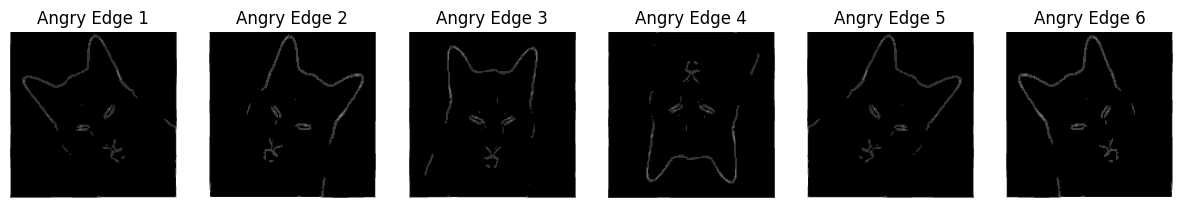

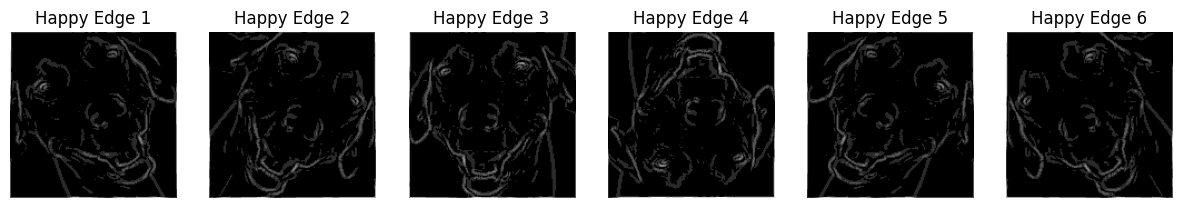

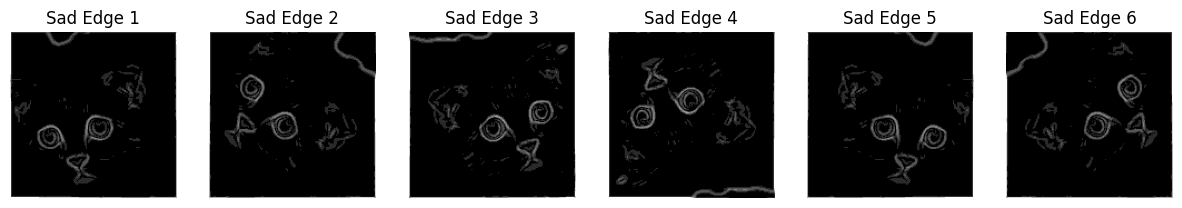

In [193]:
# Perform edge detection on all images
edge_detected_images = {folder: [deteksiTepi(img, kernelXS, kernelYS) for img in normalized_images[folder]] for folder in folder_paths}

# Display edge-detected images
for folder in folder_paths:
    plt.figure(figsize=(15, 5))
    for i in range(6):
        plt.subplot(1, 6, i+1)
        plt.imshow(edge_detected_images[folder][i], cmap='gray')
        plt.title(f'{folder} Edge {i+1}')
        plt.axis('off')
    plt.show()

In [208]:
edge_detected_images_uint8 = {folder: [img.astype(np.uint8) for img in edge_detected_images[folder]] for folder in folder_paths}

Proses konversi gambar hasil deteksi tepi ke tipe data uint8 dilakukan dalam blok kode di atas. Melalui langkah ini, gambar-gambar yang telah di-deteksi tepinya akan dikonversi ke tipe data uint8 (unsigned integer 8-bit). Konversi ini penting karena tipe data uint8 merupakan representasi yang umum digunakan untuk gambar dalam format grayscale, di mana intensitas piksel direpresentasikan dalam rentang 0 hingga 255. Dengan melakukan konversi ini, gambar-gambar hasil deteksi tepi akan disesuaikan sesuai dengan format tipe data yang umum digunakan dalam pemrosesan gambar, sehingga siap digunakan untuk tahapan analisis maupun visualisasi berikutnya.

### Thresholding

Melakukan proses thresholding menggunakan gambar-gambar hasil deteksi tepi yang telah dikonversi menjadi tipe data uint8 (edge_detected_images_uint8). Thresholding dilakukan dengan mengaplikasikan metode threshold OTSU (cv2.THRESH_OTSU) pada setiap gambar tepi yang telah dikonversi. Penggunaan metode threshold OTSU memungkinkan untuk secara otomatis menentukan nilai threshold yang optimal berdasarkan histogram intensitas pixel dari gambar. Setelah proses thresholding selesai, hasil thresholding disimpan dalam dictionary threshold_images untuk setiap kategori ekspresi wajah, dan kemudian divisualisasikan. Tampilan gambar hasil thresholding ini menunjukkan representasi biner dari gambar yang hanya mengandung dua nilai intensitas, yaitu hitam dan putih, yang berguna dalam menonjolkan area tertentu pada gambar yang memiliki nilai intensitas tertentu. Proses thresholding ini bermanfaat dalam pemrosesan dan segmentasi gambar untuk menyoroti fitur-fitur penting sebelum dilakukan analisis atau tahapan klasifikasi lanjutan.

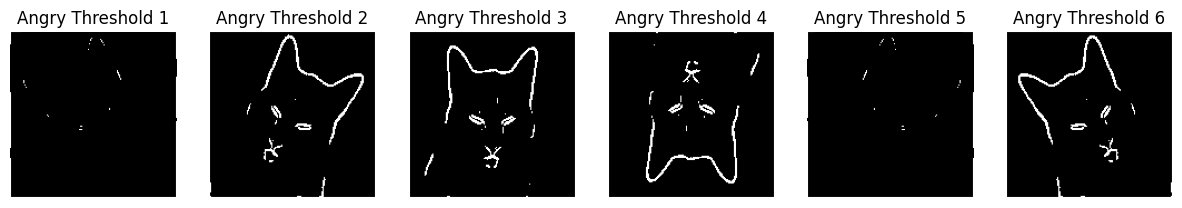

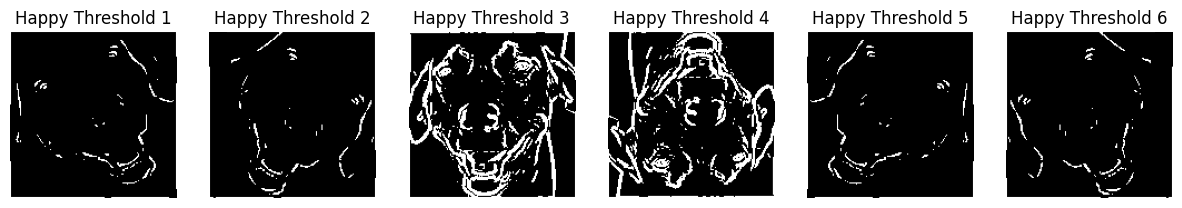

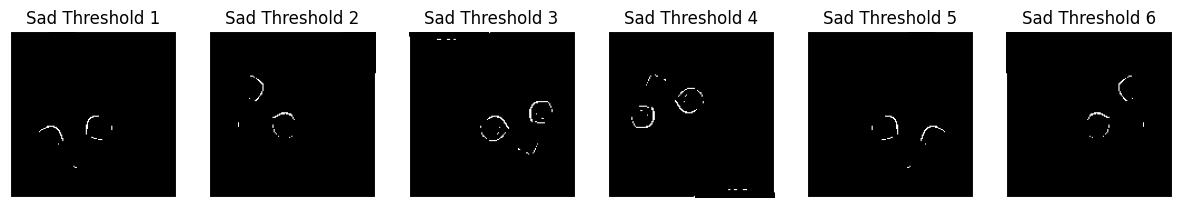

In [209]:
# Thresholding using converted edge-detected images
threshold_images = {folder: [cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1] for img in edge_detected_images_uint8[folder]] for folder in folder_paths}

# Display thresholded images
for folder in folder_paths:
    plt.figure(figsize=(15, 5))
    for i in range(6):
        plt.subplot(1, 6, i+1)
        plt.imshow(threshold_images[folder][i], cmap='gray')
        plt.title(f'{folder} Threshold {i+1}')
        plt.axis('off')
    plt.show()


### Feature Extraction

In [210]:
def calculate_glcm(edge_image):
    glcm_matrices = []
    angles = [0, 45, 90, 135]
    distances = [1, 2, 3, 4, 5]
    symmetric = True  
    
    for angle in angles:
        for distance in distances:
            glcm = np.zeros((256, 256))  
            rows, cols = edge_image.shape

            for i in range(rows):
                for j in range(cols):
                    current_pixel = edge_image[i, j]
                    neighbor_pixel_x = i + distance * np.cos(np.radians(angle))
                    neighbor_pixel_y = j - distance * np.sin(np.radians(angle))

                    if 0 <= neighbor_pixel_x < rows and 0 <= neighbor_pixel_y < cols:
                        neighbor_pixel = edge_image[int(neighbor_pixel_x), int(neighbor_pixel_y)]
                        glcm[current_pixel, neighbor_pixel] += 1
                        
                        if symmetric:
                            glcm[neighbor_pixel, current_pixel] += 1

            glcm_matrices.append(glcm)
    
    return glcm_matrices

Menggunakan GLCM untuk mengekstraksi fitur tekstur dari gambar dengan langkah pertama mempersiapkan gambar tepi (edge image), lalu pada setiap edge image matriks GLCM dihitung dengan melibatkan 2 langkah yang dimana langkah pertama dalah iterasi melalui piksel dimana inisialisasi matriks GLCM kosong (glcm) dengan ukuran 256x256, karena intensitas piksel diasumsikan berada dalam rentang 0-255, lalu yang kedua adalah pembentukan matriks dengan menambahkan matriks GLCM ke daftar glcm_matrices.

In [211]:
def calculate_glcm_features(glcm_matrices):
    features = []
    for glcm_matrix in glcm_matrices:
        # Normalisasi matriks GLCM
        glcm_matrix_normalized = glcm_matrix / np.sum(glcm_matrix)
        
        # Hitung fitur
        contrast = np.sum(glcm_matrix_normalized * np.square(np.arange(glcm_matrix.shape[0]) - np.arange(glcm_matrix.shape[1])))
        dissimilarity = np.sum(glcm_matrix_normalized * np.abs(np.arange(glcm_matrix.shape[0]) - np.arange(glcm_matrix.shape[1])))

        homogeneity = np.sum(glcm_matrix_normalized / (1 + np.square(np.arange(glcm_matrix.shape[0]) - np.arange(glcm_matrix.shape[1]))))
        energy = np.sum(np.square(glcm_matrix_normalized))
        correlation = np.sum((np.arange(glcm_matrix.shape[0]) - np.mean(glcm_matrix_normalized)) * 
                             (np.arange(glcm_matrix.shape[1]) - np.mean(glcm_matrix_normalized)) * glcm_matrix_normalized / 
                             (np.std(glcm_matrix_normalized) ** 2))
        entropy = -np.sum(glcm_matrix_normalized * np.log(glcm_matrix_normalized + 1e-10))
        asm = np.sum(np.square(glcm_matrix_normalized))
        
        features.append({
            'contrast': contrast,
            'dissimilarity': dissimilarity,
            'homogeneity': homogeneity,
            'energy': energy,
            'correlation': correlation,
            'entropy': entropy,
            'ASM': asm
        })
    return features

Lalu setelah mendapatkan matriks GLCM, kita akan menghitung fitur tekstur yang dimana fitur-fitur tersebut diantaranya adalah  kontras, dissimilarity, homogeneity, energy, correlation, entropy, dan angular second moment (ASM). 

Data fitur dari setiap gambar dan sudut kemudian diagregasi dan disimpan dalam bentuk DataFrame untuk analisis lebih lanjut sehingga didapatkan output untuk nilai dataframe dari setiap fitur yang diestrak dari gambar tepi seperti output yang terlihat diatas.

In [212]:
edge_images_prewitt_manual = [
    np.random.randint(0, 256, size=(100, 100)),
    np.random.randint(0, 256, size=(100, 100)),
]

# hitung GLCM matrices
glcm_matrices = []
for edge_image in edge_images_prewitt_manual:
    glcm_matrices.extend(calculate_glcm(edge_image))

# hitung GLCM features
glcm_features = calculate_glcm_features(glcm_matrices)

# persiapan data untuk DataFrame
data = []
columns = ['Image', 'Contrast', 'Dissimilarity', 'Homogeneity', 'Energy', 'Correlation', 'Entropy', 'ASM']
for angle in [0, 45, 90, 135]:
    columns.extend([f'contrast_{angle}', f'dissimilarity_{angle}', f'homogeneity_{angle}', 
                    f'energy_{angle}', f'correlation_{angle}', f'asm_{angle}', f'entropy_{angle}'])

for i, features in enumerate(glcm_features):
    row = [i + 1, features['contrast'], features['dissimilarity'], features['homogeneity'], 
           features['energy'], features['correlation'], features['entropy'], features['ASM']]
    for angle in [0, 45, 90, 135]:
        row.extend([features['contrast'], features['dissimilarity'], features['homogeneity'], 
                    features['energy'], features['correlation'], features['entropy'], features['ASM']])
    data.append(row)

# buat DataFrame
df = pd.DataFrame(data, columns=columns)

# tampilkan hasil
print(df)
df.head()

    Image  Contrast  Dissimilarity  Homogeneity    Energy   Correlation  \
0       1       0.0            0.0          1.0  0.000066  2.804065e+13   
1       2       0.0            0.0          1.0  0.000067  2.750631e+13   
2       3       0.0            0.0          1.0  0.000067  2.757143e+13   
3       4       0.0            0.0          1.0  0.000067  2.740601e+13   
4       5       0.0            0.0          1.0  0.000069  2.638686e+13   
5       6       0.0            0.0          1.0  0.000066  2.804335e+13   
6       7       0.0            0.0          1.0  0.000067  2.757641e+13   
7       8       0.0            0.0          1.0  0.000068  2.682486e+13   
8       9       0.0            0.0          1.0  0.000068  2.682486e+13   
9      10       0.0            0.0          1.0  0.000070  2.596134e+13   
10     11       0.0            0.0          1.0  0.000066  2.804335e+13   
11     12       0.0            0.0          1.0  0.000067  2.732136e+13   
12     13       0.0      

Image  Contrast  Dissimilarity  Homogeneity    Energy   Correlation  \
0      1       0.0            0.0          1.0  0.000066  2.804065e+13   
1      2       0.0            0.0          1.0  0.000067  2.750631e+13   
2      3       0.0            0.0          1.0  0.000067  2.757143e+13   
3      4       0.0            0.0          1.0  0.000067  2.740601e+13   
4      5       0.0            0.0          1.0  0.000069  2.638686e+13   

    Entropy       ASM  contrast_0  dissimilarity_0  ...  correlation_90  \
0  9.694274  0.000066         0.0              0.0  ...    2.804065e+13   
1  9.678164  0.000067         0.0              0.0  ...    2.750631e+13   
2  9.676339  0.000067         0.0              0.0  ...    2.757143e+13   
3  9.672816  0.000067         0.0              0.0  ...    2.740601e+13   
4  9.646777  0.000069         0.0              0.0  ...    2.638686e+13   

     asm_90  entropy_90  contrast_135  dissimilarity_135  homogeneity_135  \
0  9.694274    0.000066           0.0                0.0              1.0   
1  9.678164    0.000067           0.0                0.0              1.0   
2  9.676339    0.000067           0.0                0.0              1.0   
3  9.672816    0.000067           0.0                0.0              1.0   
4  9.646777    0.000069           0.0                0.0              1.0   

   energy_135  correlation_135   asm_135  entropy_135  
0    0.000066     2.804065e+13  9.694274     0.000066  
1    0.000067     2.750631e+13  9.678164     0.000067  
2    0.000067     2.757143e+13  9.676339     0.000067  
3    0.000067     2.740601e+13  9.672816     0.000067  
4    0.000069     2.638686e+13  9.646777     0.000069  

[5 rows x 36 columns]

### Features Selection

#### Correlation Matrix

Code ini bertujuan untuk mengidentifikasi dan menghapus fitur-fitur dalam dataset yang memiliki hubungan yang sangat kuat (lebih dari 0.9) dengan fitur lain. Hal tersebut dilakukan untuk menghindari masalah di mana beberapa fitur memberikan informasi yang hampir sama.
    
Pertama, dihitung seberapa kuat hubungan antara setiap pasangan fitur dalam dataframe. Hasilnya adalah matriks korelasi yang menunjukkan hubungan linier antara setiap pasangan fitur, dengan nilai berkisar dari -1 (hubungan negatif sempurna) hingga 1 (hubungan positif sempurna).

Selanjutnya, dibuat heatmap untuk memvisualisasikan hubungan-hubungan ini. Dalam heatmap tersebut, warna merah menunjukkan hubungan positif yang kuat, sementara warna biru menunjukkan hubungan negatif yang kuat. Angka-angka di dalam heatmap menunjukkan besarnya hubungan antara pasangan fitur.

Untuk menghindari duplikasi nilai karena matriks korelasi adalah simetris, hanya bagian atas dari matriks korelasi yang dipilih. Dari bagian atas ini, fitur-fitur yang memiliki hubungan lebih dari 0.9 dengan fitur lain diidentifikasi dan disimpan dalam daftar.

Akhirnya, fitur-fitur tersebut dihapus dari dataframe asli untuk menghindari masalah di mana beberapa fitur memberikan informasi yang hampir sama. Fitur-fitur yang dihapus karena memiliki hubungan yang sangat kuat antara lain: Energy, Correlation, ASM, Homogeneity_0, Entropy_0, Correlation_45, ASM_45, Homogeneity_45, Entropy_45, Correlation_90, ASM_90, Homogeneity_90, Entropy_90, Correlation_135, ASM_135, Homogeneity_135, dan Entropy_135.

Dengan menghapus fitur-fitur ini, dapat memastikan bahwa setiap fitur dalam dataset memberikan informasi yang unik, yang dapat meningkatkan performa analisis yang akan dibangun menggunakan data ini.

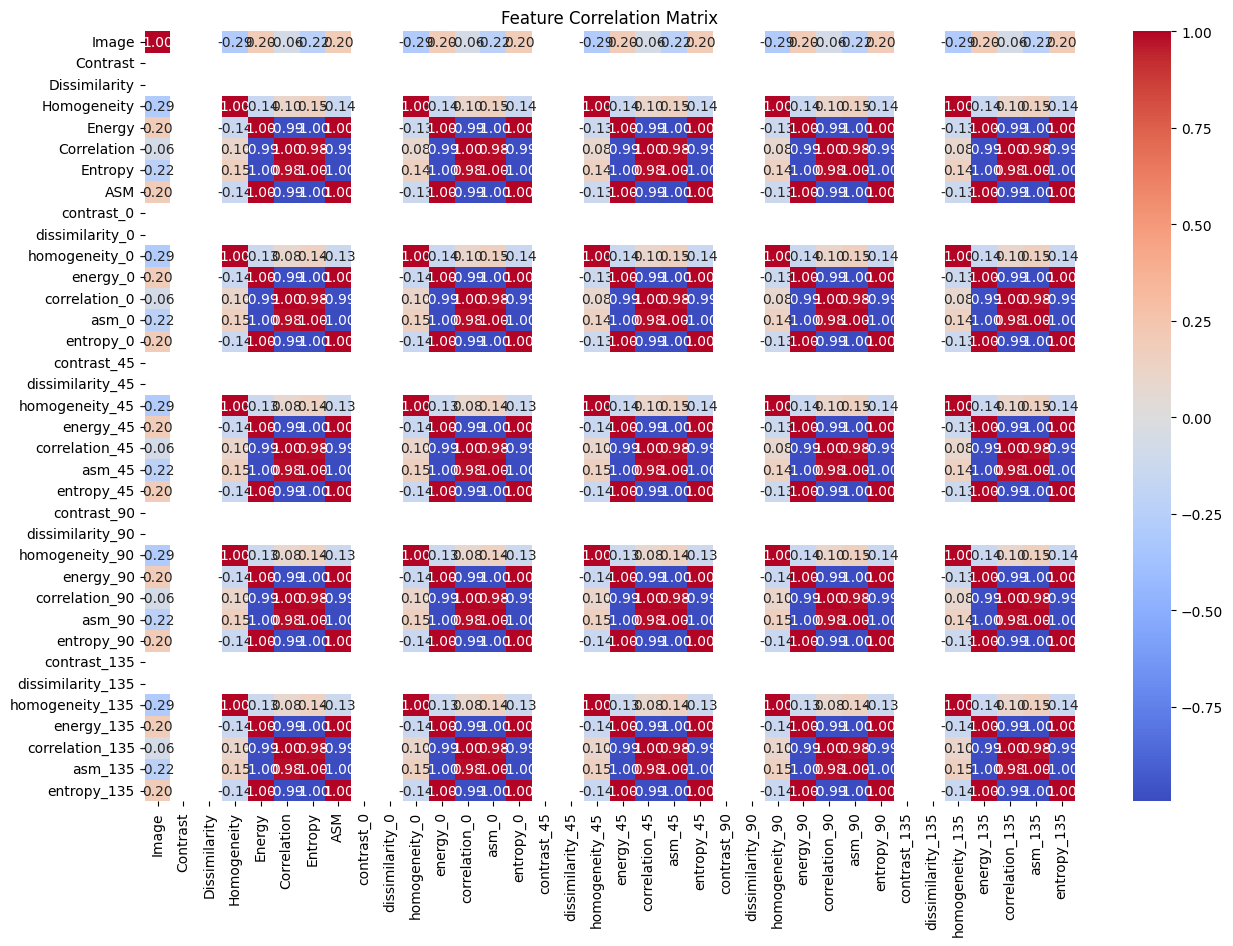

Dropped features due to high correlation: ['Entropy', 'ASM', 'homogeneity_0', 'energy_0', 'correlation_0', 'asm_0', 'entropy_0', 'homogeneity_45', 'energy_45', 'correlation_45', 'asm_45', 'entropy_45', 'homogeneity_90', 'energy_90', 'correlation_90', 'asm_90', 'entropy_90', 'homogeneity_135', 'energy_135', 'correlation_135', 'asm_135', 'entropy_135']


In [213]:
# menghitung korelasi matrix
corr_matrix = df.corr()

# plot heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

# memilih fitur yang memiliki korelasi yang tinggi
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# mengecek fitur yang memiliki korelasi yang tinggi di atas 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# menampilkan fitur
df_reduced_corr = df.drop(to_drop, axis=1)
print(f"Dropped features due to high correlation: {to_drop}")


Code ini digunakan untuk melakukan analisis komponen utama (PCA) pada dataset, dengan tujuan mengurangi dimensi data sambil mempertahankan sebanyak mungkin variansi. Proses dimulai dengan standarisasi data, memastikan bahwa setiap fitur memiliki rata-rata nol dan standar deviasi satu, yang penting karena PCA peka terhadap skala variabel. Setelah data distandarisasi, PCA diterapkan untuk memilih jumlah komponen utama yang cukup untuk menjelaskan 95% dari variansi data asli. Hasil PCA kemudian disimpan dalam sebuah DataFrame baru, dengan setiap kolom mewakili satu komponen utama. Komponen utama ini adalah kombinasi linear dari fitur asli yang memaksimalkan variansi yang dijelaskan. Variansi yang dijelaskan oleh masing-masing komponen utama, serta total variansi yang dijelaskan oleh semua komponen yang dipilih, ditampilkan untuk memberikan gambaran tentang seberapa baik komponen utama ini mewakili data asli. Hasil dari PCA menunjukkan nilai dari dua komponen utama pertama untuk lima data pertama dalam dataset, yang dalam hal ini adalah nilai-nilai PC1 dan PC2. Informasi tentang variansi yang dijelaskan membantu memahami seberapa banyak informasi dari data asli yang dipertahankan oleh komponen utama ini. Penggunaan PCA dalam code ini membantu mereduksi dimensi dataset, yang dapat membuat analisis lebih efisien dan mengurangi risiko overfitting .

#### PCA

In [214]:
# standarisasi
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df)

# menjalankan PCA
pca = PCA(n_components=0.95)  # menggunakan 95% dari variansi
principal_components = pca.fit_transform(scaled_features)

# membuat DataFrame
df_pca = pd.DataFrame(data=principal_components, 
                      columns=[f'PC{i+1}' for i in range(principal_components.shape[1])])

# menampilkan jumlah dari jenis PCA
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by each principal component: {explained_variance}")
print(f"Total explained variance: {explained_variance.sum()}")

# menampilkan DataFrame
df_pca.head()

Explained variance by each principal component: [0.94744451 0.05019219]
Total explained variance: 0.9976366948344008


PC1       PC2
0 -6.506840  1.477426
1 -2.767581  1.522943
2 -2.963695  1.372743
3 -1.859701  1.346202
4  5.185271  1.553897

### Splitting Data

In [215]:
labels = []

for folder in folder_paths:
    for filename in os.listdir(folder):
        labels.append(folder)

# Convert the label ke DataFrame
df_labels = pd.DataFrame(labels, columns=['label'])

# menggabungkan label dan fitur dari DataFrame
df_combined = pd.concat([df_labels, df], axis=1)

# cek apabila label bukan numerik
df_combined['label'] = df_combined['label'].astype('category').cat.codes

# Splitting data ke fitur (X) dan label (y)
X = df_combined.drop('label', axis=1)
y = df_combined['label']

# Split data ke training 80% dan testing 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# cek hasil dari split dataset
print(f"Training data shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Testing data shape: X_test: {X_test.shape}, y_test: {y_test.shape}")


Training data shape: X_train: (600, 36), y_train: (600,)
Testing data shape: X_test: (150, 36), y_test: (150,)


Kode di atas membuat label untuk setiap gambar dengan memindai folder gambar dan menambahkan nama folder sebagai label, kemudian mengonversi label-label ini menjadi DataFrame df_labels. DataFrame label ini digabungkan dengan DataFrame fitur df untuk membentuk df_combined, dan label dikonversi menjadi format numerik. Data dipecah menjadi fitur (X) dan label (y) dengan membuang kolom label dari X. Selanjutnya, train_test_split digunakan untuk membagi data menjadi 80% training dan 20% Testing (test_size=0.2), dengan random_state=42 untuk konsistensi. Bentuk data training (X_train: (600, 36), y_train: (600,)) dan Testing (X_test: (150, 36), y_test: (150,)) ditampilkan untuk verifikasi, menunjukkan bahwa set training memiliki 600 sampel dengan 36 fitur dan set Testing memiliki 150 sampel dengan 36 fitur.

### Normalization

In [216]:
from sklearn.impute import SimpleImputer

# Inisialisasi imputer dengan strategi pengisian rata-rata
imputer = SimpleImputer(strategy='mean')

# Mengisi nilai-nilai NaN di X_train dan X_test dengan nilai rata-rata dari masing-masing kolom
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Normalisasi data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)


Kode ini mengisi nilai-nilai yang hilang (NaN) di data training dan Testing dengan rata-rata dari masing-masing kolom menggunakan SimpleImputer dengan strategi 'mean'. Pertama, SimpleImputer diinisialisasi dan diterapkan ke data training (X_train) untuk menghitung dan mengisi nilai yang hilang, kemudian diterapkan ke data Testing (X_test). Setelah nilai-nilai yang hilang diisi, data dinormalisasi menggunakan StandardScaler, yang menstandarisasi fitur dengan menghapus rata-rata dan menskalakan ke varians unit. Proses ini diterapkan pada data training (X_train_scaled) dan data Testing (X_test_scaled).

## Modeling

#### KNN


Model K-Nearest Neighbors (KNN) diinisialisasi dengan jumlah tetangga (neighbors) sebanyak 5. Model ini kemudian dilatih menggunakan data training yang telah diskalakan, X_train_scaled, dan label y_train. Setelah itu, prediksi dilakukan pada data test yang juga telah diskalakan, X_test_scaled, menghasilkan prediksi y_pred_knn. Akurasi model dihitung dengan membandingkan prediksi terhadap label sebenarnya y_test, menghasilkan nilai akurasi yang dicetak sebagai output. Akurasi menunjukkan seberapa baik model KNN dalam mengklasifikasikan data test berdasarkan kinerja pada data training.

In [217]:
# inisialisasi model knn
knn = KNeighborsClassifier(n_neighbors=5)

# train model
knn.fit(X_train_scaled, y_train)

# Predict ke test set
y_pred_knn = knn.predict(X_test_scaled)

# mencari akurasi
knn_accuracy = accuracy_score(y_test, y_pred_knn)

print(f"KNN Accuracy: {knn_accuracy}")

KNN Accuracy: 0.3466666666666667


#### SVC

Model Support Vector Machine (SVM) diinisialisasi dengan kernel linear. Model ini kemudian dilatih menggunakan data training yang telah diskalakan, X_train_scaled, dan label y_train. Setelah pelatihan, prediksi dilakukan pada data test yang juga telah diskalakan, X_test_scaled, menghasilkan prediksi y_pred_svm. Akurasi model dihitung dengan membandingkan prediksi terhadap label sebenarnya y_test, menghasilkan nilai akurasi yang dicetak sebagai output. Akurasi ini menunjukkan seberapa baik model SVM dengan kernel linear dalam mengklasifikasikan data test berdasarkan kinerja pada data training.

In [218]:
# inisialisasi model svm
svm = SVC(kernel='linear')

# Train model
svm.fit(X_train_scaled, y_train)

# Predict ke test set
y_pred_svm = svm.predict(X_test_scaled)

# mencari akurasi
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {svm_accuracy}")

SVM Accuracy: 0.2866666666666667


#### RANDOM FOREST

Model Random Forest diinisialisasi dengan 100 pohon keputusan (n_estimators=100) dan parameter random_state diatur ke 42 untuk memastikan reproduktifitas hasil. Model ini dilatih menggunakan data training yang telah diskalakan, X_train_scaled, dan label y_train. Setelah pelatihan, prediksi dilakukan pada data test yang juga telah diskalakan, X_test_scaled, menghasilkan prediksi y_pred_rf. Akurasi model dihitung dengan membandingkan prediksi terhadap label sebenarnya y_test, menghasilkan nilai akurasi yang dicetak sebagai output. Akurasi ini mencerminkan kinerja model Random Forest dalam mengklasifikasikan data test berdasarkan pembelajaran dari data training.

In [219]:
# inisialisasi model random forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train model
rf.fit(X_train_scaled, y_train)

# Predict ke test set
y_pred_rf = rf.predict(X_test_scaled)

# mencari akurasi
rf_accuracy = accuracy_score(y_test, y_pred_rf)

print(f"Random Forest Accuracy: {rf_accuracy}")

Random Forest Accuracy: 0.34


## Evaluation

cm_knn: Menghitung confusion matrix untuk model KNN, yang menunjukkan jumlah prediksi benar dan salah.
accuracy_knn: Menghitung akurasi model KNN, yaitu proporsi prediksi benar dari total prediksi.
precision_knn: Menghitung precision model KNN dengan metode weighted average, yaitu rata-rata precision yang dihitung berdasarkan kontribusi setiap kelas.
recall_knn: Menghitung recall model KNN dengan metode weighted average, yaitu rata-rata recall yang dihitung berdasarkan kontribusi setiap kelas.
f1_knn: Menghitung f1-score model KNN dengan metode weighted average, yaitu rata-rata harmonic mean dari precision dan recall yang dihitung berdasarkan kontribusi setiap kelas.

cm_svm: Menghitung confusion matrix untuk model SVM.
accuracy_svm: Menghitung akurasi model SVM.
precision_svm: Menghitung precision model SVM dengan metode weighted average.
recall_svm: Menghitung recall model SVM dengan metode weighted average.
f1_svm: Menghitung f1-score model SVM dengan metode weighted average.

cm_rf: Menghitung confusion matrix untuk model Random Forest.
accuracy_rf: Menghitung akurasi model Random Forest.
precision_rf: Menghitung precision model Random Forest dengan metode weighted average.
recall_rf: Menghitung recall model Random Forest dengan metode weighted average.
f1_rf: Menghitung f1-score model Random Forest dengan metode weighted average.

evaluation_results: Membuat DataFrame yang berisi hasil evaluasi untuk setiap model. Kolom Model berisi nama-nama model yang dievaluasi, dan kolom-kolom Accuracy, Precision, Recall, serta f1-score berisi nilai metrik yang telah dihitung sebelumnya untuk masing-masing model.

Menampilkan DataFrame evaluation_results yang telah dibuat, yang memuat hasil evaluasi model-model tersebut.

In [220]:
# KNN
cm_knn = confusion_matrix(y_test, y_pred_knn)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn, average='weighted')
recall_knn = recall_score(y_test, y_pred_knn, average='weighted')
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')

# SVM
cm_svm = confusion_matrix(y_test, y_pred_svm)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm, average='weighted')
recall_svm = recall_score(y_test, y_pred_svm, average='weighted')
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')

# Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

# Create DataFrame
evaluation_results = pd.DataFrame({
    'Model': ['K-Nearest Neighbors', 'Support Vector Machine', 'Random Forest'],
    'Accuracy': [accuracy_knn, accuracy_svm, accuracy_rf],
    'Precision': [precision_knn, precision_svm, precision_rf],
    'Recall': [recall_knn, recall_svm, recall_rf],
    'f1-score': [f1_knn, f1_svm, f1_rf]
})

# menampilkan DataFrame
print("Tabel Hasil Evaluasi:")
evaluation_results


Tabel Hasil Evaluasi:


c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Model  Accuracy  Precision    Recall  f1-score
0     K-Nearest Neighbors  0.346667   0.120178  0.346667  0.178482
1  Support Vector Machine  0.286667   0.082178  0.286667  0.127737
2           Random Forest  0.340000   0.433474  0.340000  0.225706

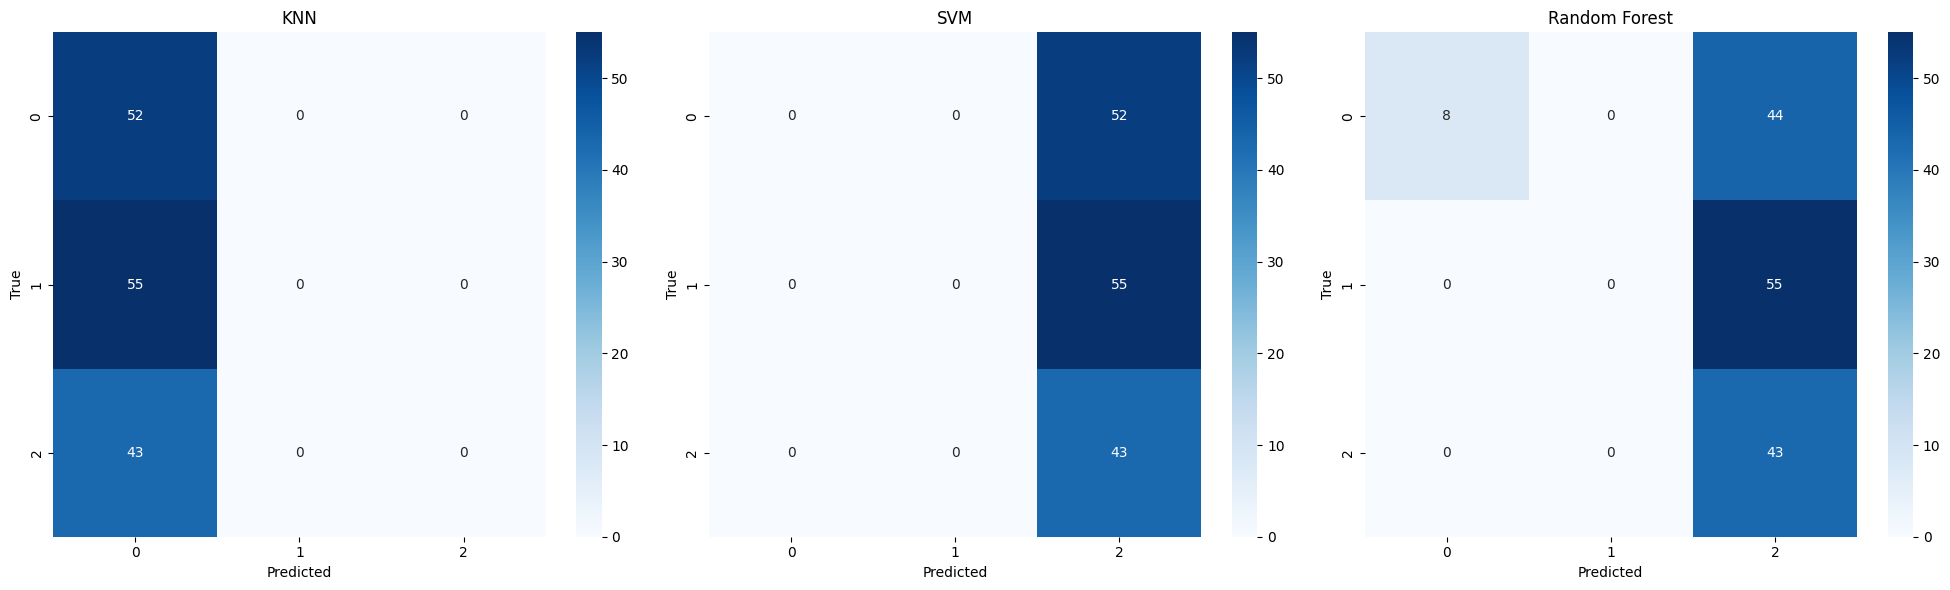

In [221]:
# Plot confusion matriks sisi demi sisi
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

sns.heatmap(cm_knn, annot=True, fmt='g', ax=axes[0], cmap='Blues')
axes[0].set_title('KNN')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

sns.heatmap(cm_svm, annot=True, fmt='g', ax=axes[1], cmap='Blues')
axes[1].set_title('SVM')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

sns.heatmap(cm_rf, annot=True, fmt='g', ax=axes[2], cmap='Blues')
axes[2].set_title('Random Forest')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(20, 6)): Membuat sebuah figure dengan tiga subplot yang disusun secara horizontal (1, 3). Ukuran keseluruhan figure diatur menjadi 20x6 inci.

sns.heatmap(cm_knn, annot=True, fmt='g', ax=axes[0], cmap='Blues'): Membuat heatmap untuk confusion matrix dari model KNN (cm_knn). Parameter annot=True digunakan untuk menampilkan nilai-nilai dalam confusion matrix, fmt='g' memastikan nilai-nilai ditampilkan sebagai bilangan bulat, ax=axes[0] menentukan subplot pertama sebagai tempat menampilkan heatmap, dan cmap='Blues' mengatur warna heatmap.

axes[0].set_title('KNN'): Menambahkan judul "KNN" pada subplot pertama.
axes[0].set_xlabel('Predicted'): Menambahkan label "Predicted" pada sumbu x subplot pertama.
axes[0].set_ylabel('True'): Menambahkan label "True" pada sumbu y subplot pertama.

sns.heatmap(cm_svm, annot=True, fmt='g', ax=axes[1], cmap='Blues'): Membuat heatmap untuk confusion matrix dari model SVM (cm_svm) pada subplot kedua.
axes[1].set_title('SVM'): Menambahkan judul "SVM" pada subplot kedua.
axes[1].set_xlabel('Predicted'): Menambahkan label "Predicted" pada sumbu x subplot kedua.
axes[1].set_ylabel('True'): Menambahkan label "True" pada sumbu y subplot kedua.

sns.heatmap(cm_rf, annot=True, fmt='g', ax=axes[2], cmap='Blues'): Membuat heatmap untuk confusion matrix dari model Random Forest (cm_rf) pada subplot ketiga.
axes[2].set_title('Random Forest'): Menambahkan judul "Random Forest" pada subplot ketiga.
axes[2].set_xlabel('Predicted'): Menambahkan label "Predicted" pada sumbu x subplot ketiga.
axes[2].set_ylabel('True'): Menambahkan label "True" pada sumbu y subplot ketiga.

plt.tight_layout(): Menyesuaikan layout subplot agar tidak saling tumpang tindih dan memberikan ruang yang cukup antar subplot.
plt.show(): Menampilkan gambar yang telah dibuat.